# End-to-End Training Pipeline

In [1]:
import os
import gc
import sys
SRC_PATH = '../src'
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
import utils
import pyarrow

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

from joblib import parallel_backend

In [2]:
# dask progress bar
pbar = ProgressBar()
pbar.register()

# # dask parallel backend client
# client = Client()

In [3]:
# define thresholds as timedelta
BAD_THRESHOLD_NDAYS = np.timedelta64(14, 'D')
WARNING_THRESHOLD_NDAYS = np.timedelta64(42, 'D')

## Data Ingestion

In [4]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [5]:
# read all the data into one dataframe
# NOTE: assumes aws credentials are stored as env vars or in ~/.aws/credentials
DATA_ROOT_DIR = '/home/kachauha/Downloads/'
df4 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q4_2018_parquet'), engine='pyarrow', index=False)
df3 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q3_2018_parquet'), engine='pyarrow', index=False)
df = dd.concat(dfs=[df3, df4], interleave_partitions=True)

# deal with only seagate in this notebook
seagate_df = utils.optimal_repartition_df(df[df['model'].str.startswith('S')])

[########################################] | 100% Completed | 50.6s


In [6]:
# convert from str to datetime
seagate_df['date'] = seagate_df['date'].astype('datetime64')

In [7]:
# get failed serial numbers
failed_sers = seagate_df[seagate_df['failure']==1]['serial_number'].compute()
failed_sers.head()

[########################################] | 100% Completed | 27.8s


8963     ZA12624Y
70357    S300Z4Y3
4285     Z300K1Z7
99943    W300L6AL
4487     Z3025LEN
Name: serial_number, dtype: object

## Feature Selection

In [8]:
# start off with critical columns as indicated from 3 sources
CRITICAL_STATS = [1, 5, 7, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242]

# NOTE - THESE LISTS ARE SUBJECT TO CHANGE
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

In [9]:
print('Seagate')
seagate_nan_ct = utils.get_nan_count_percent(seagate_df[crit_cols_raw + crit_cols_normalized])
seagate_nan_ct.compute()

Seagate


,count,percent
smart_1_raw,367,0.000026
smart_5_raw,867,0.000061
smart_7_raw,867,0.000061
smart_10_raw,867,0.000061
smart_184_raw,4783905,0.334475
smart_187_raw,112942,0.007897
smart_188_raw,112942,0.007897
smart_189_raw,4783905,0.334475
smart_190_raw,112942,0.007897
smart_193_raw,114007,0.007971


In [10]:
seagate_corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
seagate_corr = seagate_df[seagate_corr_cols].corr().compute()
seagate_corr['failure'].abs().sort_values(ascending=False)

failure                 1.000000
smart_197_raw           0.071970
smart_198_raw           0.071965
smart_187_normalized    0.048009
smart_187_raw           0.045364
smart_5_raw             0.033866
smart_7_raw             0.015851
smart_184_normalized    0.006764
smart_184_raw           0.006764
smart_10_normalized     0.001883
smart_188_raw           0.001669
smart_5_normalized      0.001531
smart_198_normalized    0.001486
capacity_bytes          0.001405
smart_193_normalized    0.001357
smart_241_raw           0.001145
smart_193_raw           0.001085
smart_194_raw           0.001052
smart_190_normalized    0.001031
smart_190_raw           0.001031
smart_7_normalized      0.000905
smart_197_normalized    0.000782
smart_1_normalized      0.000742
smart_242_raw           0.000425
smart_1_raw             0.000264
smart_189_normalized    0.000213
smart_194_normalized    0.000093
smart_189_raw           0.000044
smart_240_raw           0.000002
smart_10_raw                 NaN
smart_196_

In [11]:
# re-selection of critical columns based on number of nans and correlations
CRITICAL_STATS = [1, 5, 7, 10, 187, 188, 190, 193, 194, 197, 198, 240, 241, 242]
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

In [12]:
seagate_corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
seagate_corr = seagate_df[seagate_corr_cols].corr().compute()
seagate_corr['failure'].abs().sort_values(ascending=False)

failure                 1.000000
smart_197_raw           0.071970
smart_198_raw           0.071965
smart_187_normalized    0.048009
smart_187_raw           0.045364
smart_5_raw             0.033866
smart_7_raw             0.015851
smart_10_normalized     0.001883
smart_188_raw           0.001669
smart_5_normalized      0.001531
smart_198_normalized    0.001486
capacity_bytes          0.001405
smart_193_normalized    0.001357
smart_241_raw           0.001145
smart_193_raw           0.001085
smart_194_raw           0.001052
smart_190_normalized    0.001031
smart_190_raw           0.001031
smart_7_normalized      0.000905
smart_197_normalized    0.000782
smart_1_normalized      0.000742
smart_242_raw           0.000425
smart_1_raw             0.000264
smart_194_normalized    0.000093
smart_240_raw           0.000002
smart_10_raw                 NaN
smart_188_normalized         NaN
smart_240_normalized         NaN
smart_241_normalized         NaN
smart_242_normalized         NaN
Name: fail

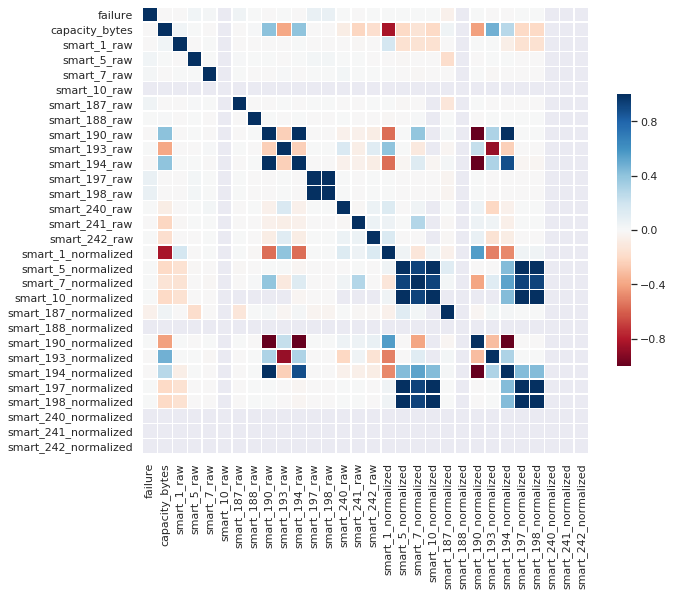

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(seagate_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

In [14]:
seagate_corr['smart_5_normalized']['smart_198_normalized']

0.9999071374115623

**NOTES**
1. 190 is temperature, and 194 is temperature difference, i.e. almost completely correlated. Therefore we can remove one. Removing 194 is better because it is more correlated to some other features (smart_5_normalized) than 190 is.
2. Normalized 5, 7, 10, 197, 198 are highly correlated

In [15]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [16]:
# make sure we remove nans - sklearn doesnt deal well with those
test_df = seagate_df[['failure', 'smart_5_normalized', 'smart_7_normalized', 'smart_10_normalized', 'smart_197_normalized', 'smart_198_normalized']].dropna()
test_df.isna().any().any().compute()

False

In [17]:
# split
test_X = test_df.drop('failure', axis=1)
test_y = test_df['failure']

In [18]:
with parallel_backend('dask'):
    # inspect deeper into highly correlated features
    print(chi2(test_X, test_y))

(array([59.49062003, 32.70783332, 90.00985241, 15.44540977, 56.06036256]), array([1.22878412e-14, 1.07104718e-08, 2.36976979e-21, 8.49229521e-05,
       7.02798072e-14]))


In [19]:
# want big values
with parallel_backend('dask'):
    # inspect deeper into highly correlated features
    print(f_classif(test_X, test_y))

(array([-24.14215255,  40.03846428, -14.97191752, -28.241386  ,
       -23.04656271]), array([           nan, 2.49018252e-10,            nan,            nan,
                  nan]))


In [8]:
# for now, keep the highly correlated ones but remove 194. remove 240, 242 as well (too low corr)
CRITICAL_STATS = [1, 5, 7, 10, 187, 188, 190, 193, 197, 198, 241]
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]
seagate_df = seagate_df[['date', 'serial_number', 'model', 'capacity_bytes', 'failure'] + crit_cols_raw + crit_cols_normalized]

## Handle Missing Values

In [21]:
# what is the nan situation like
utils.get_nan_count_percent(seagate_df).compute()

,count,percent
date,0,0.000000
serial_number,0,0.000000
model,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,367,0.000026
smart_5_raw,867,0.000061
smart_7_raw,867,0.000061
smart_10_raw,867,0.000061
smart_187_raw,112942,0.007897


In [22]:
# failed drives that have nan values
failed_df = seagate_df[seagate_df['serial_number'].isin(failed_sers)]
len_failed_df = len(failed_df)
utils.get_nan_count_percent(failed_df, divisor=len_failed_df).compute()

,count,percent
date,0,0.000000
serial_number,0,0.000000
model,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,3,0.000052
smart_5_raw,3,0.000052
smart_7_raw,3,0.000052
smart_10_raw,3,0.000052
smart_187_raw,1951,0.034098


In [23]:
# # =============================== FOR DASK =============================== #
# # create meta of the resulting failed_df otherwise dask complains
# rul_meta = seagate_df._meta
# rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# # ======================================================================== #

# # get remaining useful life as diff(today, maxday)
# # reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
# seagate_df = seagate_df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [24]:
# # how many drives had nan values close to fail day
# utils.get_nan_count_percent(failed_df[failed_df['rul_days']<=BAD_THRESHOLD_NDAYS], divisor=len_failed_df).compute()

KeyError: 'rul_days'

In [ ]:
# # how many drives had nan values exactly on fail day
# utils.get_nan_count_percent(failed_df[failed_df['failure']==1], divisor=len_failed_df).compute()

In [9]:
# drop the nans that occur in working hard drives, keep the ones in failing ones for now
seagate_df = seagate_df[(seagate_df['serial_number'].isin(failed_sers))\
                       | ((~seagate_df['smart_1_raw'].isna())\
                       & (~seagate_df['smart_5_raw'].isna())\
                       & (~seagate_df['smart_187_raw'].isna())\
                       & (~seagate_df['smart_193_raw'].isna())\
                       & (~seagate_df['smart_241_raw'].isna()))]

# shouldnt have any nan values from working drives now
utils.get_nan_count_percent(seagate_df).compute()

[########################################] | 100% Completed | 33.3s
[########################################] | 100% Completed | 34.7s


,count,percent
date,0,0.000000e+00
serial_number,0,0.000000e+00
model,0,0.000000e+00
capacity_bytes,0,0.000000e+00
failure,0,0.000000e+00
smart_1_raw,3,2.114359e-07
smart_5_raw,3,2.114359e-07
smart_7_raw,3,2.114359e-07
smart_10_raw,3,2.114359e-07
smart_187_raw,1951,1.375038e-04


In [10]:
# wont lose too many points if we just drop nans for failed ones
seagate_df = seagate_df[(~seagate_df['smart_1_raw'].isna())\
                       & (~seagate_df['smart_5_raw'].isna())\
                       & (~seagate_df['smart_187_raw'].isna())\
                       & (~seagate_df['smart_193_raw'].isna())\
                       & (~seagate_df['smart_241_raw'].isna())]

# ensure no more nans
utils.get_nan_count_percent(seagate_df).compute()

[########################################] | 100% Completed | 32.8s
[########################################] | 100% Completed | 35.0s


,count,percent
date,0,0.0
serial_number,0,0.0
model,0,0.0
capacity_bytes,0,0.0
failure,0,0.0
smart_1_raw,0,0.0
smart_5_raw,0,0.0
smart_7_raw,0,0.0
smart_10_raw,0,0.0
smart_187_raw,0,0.0


## Prepare + Preprocess

### Add RUL, Class labels

In [11]:
# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = seagate_df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
seagate_df = seagate_df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [12]:
# remove working drive data that is recorded after [quarter end minus 6 weeks]
# because we dont know (as of quarter end) if those drives survived more than 6 weeks or not
seagate_df = seagate_df[(seagate_df['serial_number'].isin(failed_sers)) | (seagate_df['rul_days'] >= WARNING_THRESHOLD_NDAYS)]
# print(dd.compute(seagate_df.shape))

In [13]:
# NOTE: assignment must be done in th
# df.head()is order otherwise it wont be correct. FIXME
# assign all as good initially
seagate_df['status'] = 0

# overwrite those which have rul less than 6 weeks as warning
seagate_df['status'] = seagate_df['status'].mask(seagate_df['rul_days'] < WARNING_THRESHOLD_NDAYS, 1)

# overwrite those which have rul less than 2 weeks as bad
seagate_df['status'] = seagate_df['status'].mask(seagate_df['rul_days'] < BAD_THRESHOLD_NDAYS, 2)

In [14]:
seagate_df = utils.optimal_repartition_df(seagate_df)

[########################################] | 100% Completed |  4min 45.5s


### Downsample
Here, we randomly sample `n` serial numbers from the "working" category to be representative serial numbers for working drives. A different sampling method (e.g. kmeans) could provide better representatives than random sampling. However, for simplicity, and because the dataset is huge and the number of dimensions high and `dask_ml` does not have kernel kmeans, we'll stick to random sampling.

In [15]:
num_working_serials = 7500
working_sers = seagate_df[~seagate_df['serial_number'].isin(failed_sers)]['serial_number'].unique()
working_repr_sers = working_sers.sample(frac=(num_working_serials/len(working_sers))).compute()

[########################################] | 100% Completed |  4min 26.6s
[########################################] | 100% Completed |  4min  9.9s


In [16]:
# preprocess only downsampled data
seagate_df = seagate_df[(seagate_df['serial_number'].isin(failed_sers)) | seagate_df['serial_number'].isin(working_repr_sers)].compute()

[########################################] | 100% Completed |  4min 11.5s


### OPTION 1: Keep data as-is
This option has been experimented with, and the results were not as good as OPTION 2, so it is not being included in this notebook.

### OPTION 2: 6-day rolling features
Since we'll have 6 days of data at inference time, we might as well use it. In this option, we look at the behavior of metrics over teh past six days, and use that "behavior" as the features.
To characterize the past 6 day behavior, we use mean, standard deviation and coefficient of variation.

In [17]:
def rolling_featurize(df, window=6, drop_cols=('date', 'failure', 'capacity_bytes', 'rul'), group_cols=('serial_number'), cap=True):
    """
    Extracts 6-day rolling features (6-day mean, std, coefficient of variation) from raw data
    in a pandas dataframe
    """
    # save the status labels
    # FIXME: if this is not a df, then earlier versions of pandas (0.19) complains
    statuses = df[['status']]

    # group by serials, drop cols which are not to be aggregated
    if drop_cols is not None:
        grouped_df = df.drop(drop_cols, axis=1).groupby(group_cols)
    else:
        grouped_df = df.groupby(group_cols)
        
    # feature columns
    featcols = grouped_df.first().columns
    
    # get mean value in last 6 days
    means = grouped_df.rolling(window)[featcols].mean()
    
    # get std in last 6 days
    stds = grouped_df.rolling(window)[featcols].std()
    
    # coefficient of variation
    cvs = stds.divide(means, fill_value=0)

    # rename before mergeing
    means = means.rename(columns={col: 'mean_' + col for col in means.columns})
    stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})
    cvs = cvs.rename(columns={col: 'cv_' + col for col in cvs.columns})
    
    # combine features into one df
    res = means.merge(stds, left_index=True, right_index=True)
    res = res.merge(cvs, left_index=True, right_index=True)
    
    # drop rows where all columns are nans
    res = res.dropna(how='all')
    
    # fill nans created by cv calculation
    res = res.fillna(0)
    
    # capacity of hard drive
    if cap:
        capacities = df[['serial_number', 'capacity_bytes']].groupby('serial_number').max()
        res = res.merge(capacities, left_index=True, right_index=True)
        
    # bring serial number back as a col instead of index, preserve the corresponding indices
    res = res.reset_index(level=[0])

    # add status labels back.
    res = res.merge(statuses, left_index=True, right_index=True)
    
    return res

In [22]:
# MUST make sure indices are unique before processing
seagate_df = seagate_df.reset_index(drop=True)
seagate_feats_df = rolling_featurize(seagate_df,
                                        window=6,
                                        drop_cols=['date', 'model', 'capacity_bytes', 'failure', 'rul_days', 'status'],
                                        group_cols=['serial_number'])

# infinities get added to df - remove these
seagate_feats_df = seagate_feats_df.replace([np.inf, -np.inf], np.nan).dropna()

seagate_feats_df.head()

,serial_number,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,mean_smart_197_raw,...,cv_smart_10_normalized,cv_smart_187_normalized,cv_smart_188_normalized,cv_smart_190_normalized,cv_smart_193_normalized,cv_smart_197_normalized,cv_smart_198_normalized,cv_smart_241_normalized,capacity_bytes,status
254208,S3001HBH,1.262889e+08,0.0,3.766955e+08,0.0,0.0,0.0,25.500000,11558.5,0.0,...,0.0,0.0,0.0,0.007352,0.0,0.0,0.0,0.0,4.000787e+12,0
254209,S3001HBH,1.171115e+08,0.0,3.784549e+08,0.0,0.0,0.0,25.333333,11559.0,0.0,...,0.0,0.0,0.0,0.006916,0.0,0.0,0.0,0.0,4.000787e+12,0
254210,S3001HBH,1.213544e+08,0.0,3.799755e+08,0.0,0.0,0.0,25.333333,11559.5,0.0,...,0.0,0.0,0.0,0.006916,0.0,0.0,0.0,0.0,4.000787e+12,0
254211,S3001HBH,1.401337e+08,0.0,3.816019e+08,0.0,0.0,0.0,25.333333,11560.0,0.0,...,0.0,0.0,0.0,0.006916,0.0,0.0,0.0,0.0,4.000787e+12,0
254212,S3001HBH,1.177364e+08,0.0,3.833191e+08,0.0,0.0,0.0,25.500000,11560.5,0.0,...,0.0,0.0,0.0,0.007352,0.0,0.0,0.0,0.0,4.000787e+12,0


### OPTION 3: 6-day expanding features
This option is similar to option 2, but uses expanding window instead of rolling window. This setup has not been test out yet, but is put here to try to give ideas to the user :)

In [ ]:
# ========================================================================= #
#                             UNTESTED FUNCTION                             #
# ========================================================================= #
def test_expanding(df, drop_cols=('date', 'failure', 'capacity_bytes', 'rul'), group_cols=('serial_number'), cap=True, num_days=False):
    # group by serials, drop cols which are not to be aggregated
    if drop_cols is not None:
        grouped_df = df.drop(drop_cols, axis=1).groupby(group_cols)
    else:
        grouped_df = df.groupby(group_cols)

    # rolling window mean. drop the group_cols since they dont vary in a group
    # .drop(group_cols, axis=1)
    means = grouped_df.expanding()[[col for col in grouped_df.first().columns if col not in group_cols]].mean()
    means = means.rename(columns={col: 'mean_' + col for col in means.columns})
    
    # rolling window srd. drop the group_cols since they dont vary in a group
    stds = grouped_df.expanding()[[col for col in grouped_df.first().columns if col not in group_cols]].std(ddof=0)
    stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})

    # combine features into one df
    feats = means.merge(stds, left_index=True, right_index=True)
    
    # capacity of hard drive
    if cap:
        capacities = df[['serial_number', 'capacity_bytes']].groupby('serial_number').max()
        feats = feats.merge(capacities, left_index=True, right_index=True)
    
    # number of days of observed data available
    if num_days:
        days_per_drive = grouped_df.size().to_frame('num_days')
        feats = feats.merge(days_per_drive, left_index=True, right_index=True)

    return feats

### Stratified, Drive-wise Train/Test Split

Train/Test split has to be done carefully. If `train_test_split` is called on the data naively, then there is a chance of data leak across train/test sets. Since we have multiple rows for a given serial number, naive train/test splitting could result in a split such data from the same drive but adjacent days are in different sets.

E.g. drive FOO day 32 is in train and drive FOO day 33 is in test. Since the difference between adjacent days would generally not be too much, the results will be skewed since our model will be evaluated on data that is very very similar to the data it has seen before.

Therefore, we split data by serial numbers i.e. model trains on data from some serial numbers, and is evaluated on data from other serial numbers.

In [24]:
# split into X,Y
X_arr = seagate_feats_df.drop(['serial_number', 'status'], axis=1)
Y_arr = seagate_feats_df[['serial_number', 'status']]

del seagate_feats_df
gc.collect()

0

In [25]:
# split by serial number
# failed serials left after reduction
failed_sers_red = pd.Series(Y_arr['serial_number'].unique())
failed_sers_red = failed_sers_red[failed_sers_red.isin(failed_sers)]

# working serials left after reduction
working_sers_red = pd.Series(Y_arr['serial_number'].unique())
working_sers_red = working_sers_red[~working_sers_red.isin(failed_sers)]

In [28]:
from sklearn.model_selection import train_test_split

# split working and failed
working_train, working_test = train_test_split(working_sers_red, test_size=0.2, random_state=42)
failed_train, failed_test = train_test_split(failed_sers_red, test_size=0.2, random_state=42)

In [29]:
# use serial numbers to generate train/test set
# CHECKED OK - train/test ratio 0.8, fail/work and overall both
X_train_work = X_arr[Y_arr['serial_number'].isin(working_train)]
X_train_fail = X_arr[Y_arr['serial_number'].isin(failed_train)]
X_train = pd.concat([X_train_work, X_train_fail])
del X_train_work, X_train_fail

Y_train_work = Y_arr[Y_arr['serial_number'].isin(working_train)]['status']
Y_train_fail = Y_arr[Y_arr['serial_number'].isin(failed_train)]['status']
Y_train = pd.concat([Y_train_work, Y_train_fail])
del Y_train_work, Y_train_fail

X_test_work = X_arr[Y_arr['serial_number'].isin(working_test)]
X_test_fail = X_arr[Y_arr['serial_number'].isin(failed_test)]
X_test = pd.concat([X_test_work, X_test_fail])
del X_test_work, X_test_fail

Y_test_work = Y_arr[Y_arr['serial_number'].isin(working_test)]['status']
Y_test_fail = Y_arr[Y_arr['serial_number'].isin(failed_test)]['status']
Y_test = pd.concat([Y_test_work, Y_test_fail])
del Y_test_work, Y_test_fail

### Scale

In [30]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [31]:
# trecolumnsas regular dataset and scale
# with parallel_backend('dask'):
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Train

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

### Vanilla Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [35]:
# with joblib.parallel_backend('dask'):
dt_clf = DecisionTreeClassifier(class_weight='balanced')
dt_clf.fit(X_train_scaled, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
# get preds
dt_preds = dt_clf.predict(scaler.transform(X_test))
dt_confmat = confusion_matrix(Y_test, dt_preds)

print(np.around(dt_confmat, decimals=2))
print(classification_report(Y_test, dt_preds, target_names=['good', 'warning', 'bad']))

[[193017   1769   1341]
 [  2301    174    190]
 [  1190    121    214]]
              precision    recall  f1-score   support

        good       0.98      0.98      0.98    196127
     warning       0.08      0.07      0.07      2665
         bad       0.12      0.14      0.13      1525

    accuracy                           0.97    200317
   macro avg       0.40      0.40      0.40    200317
weighted avg       0.96      0.97      0.96    200317



### Vanilla Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf_clf = RandomForestClassifier(n_estimators=128, class_weight='balanced', n_jobs=-1)
rf_clf.fit(X_train_scaled, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=128,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [41]:
# get preds
rf_preds = rf_clf.predict(scaler.transform(X_test))
rf_confmat = confusion_matrix(Y_test, rf_preds)

print(np.around(rf_confmat, decimals=2))
print(classification_report(Y_test, rf_preds, target_names=['good', 'warning', 'bad']))

[[195987     66     74]
 [  2557     26     82]
 [  1318     14    193]]
              precision    recall  f1-score   support

        good       0.98      1.00      0.99    196127
     warning       0.25      0.01      0.02      2665
         bad       0.55      0.13      0.21      1525

    accuracy                           0.98    200317
   macro avg       0.59      0.38      0.40    200317
weighted avg       0.97      0.98      0.97    200317



## RGF

In [42]:
from rgf.sklearn import RGFClassifier

In [ ]:
rgf_clf = RGFClassifier(max_leaf=2500, l2=1e-10, learning_rate=0.01)
rgf_clf.fit(X_train_scaled, Y_train)

In [ ]:
# get preds
rgf_preds = rgf_clf.predict(scaler.transform(X_test))
rgf_confmat = confusion_matrix(Y_test, rgf_preds)

print(np.around(rgf_confmat / rgf_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, rgf_preds, target_names=['good', 'warning', 'bad']))